###integrasi kaggle

In [1]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d rm1000/lung-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/rm1000/lung-cancer-histopathological-images
License(s): CC-BY-SA-4.0
100% 1.55G/1.55G [01:11<00:00, 23.4MB/s]
100% 1.55G/1.55G [01:11<00:00, 23.3MB/s]


In [5]:
!unzip /content/lung-cancer-histopathological-images.zip -d /content/LungCancerHistopathological

Streaming output truncated to the last 5000 lines.
  inflating: /content/LungCancerHistopathological/squamous_cell_carcinoma/0000.jpg  
  inflating: /content/LungCancerHistopathological/squamous_cell_carcinoma/0001.jpg  
  inflating: /content/LungCancerHistopathological/squamous_cell_carcinoma/0002.jpg  
  inflating: /content/LungCancerHistopathological/squamous_cell_carcinoma/0003.jpg  
  inflating: /content/LungCancerHistopathological/squamous_cell_carcinoma/0004.jpg  
  inflating: /content/LungCancerHistopathological/squamous_cell_carcinoma/0005.jpg  
  inflating: /content/LungCancerHistopathological/squamous_cell_carcinoma/0006.jpg  
  inflating: /content/LungCancerHistopathological/squamous_cell_carcinoma/0007.jpg  
  inflating: /content/LungCancerHistopathological/squamous_cell_carcinoma/0008.jpg  
  inflating: /content/LungCancerHistopathological/squamous_cell_carcinoma/0009.jpg  
  inflating: /content/LungCancerHistopathological/squamous_cell_carcinoma/0010.jpg  
  inflating: /

###load data and preprocessing

In [35]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import tensorflowjs as tfjs
import seaborn as sns

In [14]:
base_dir = "/content/LungCancerHistopathological"

In [15]:
img_size = (150, 150)
batch_size = 32

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 15000 images belonging to 3 classes.


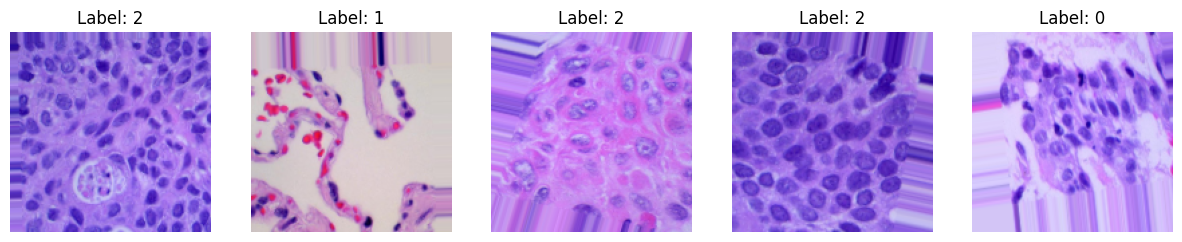

In [24]:
images, labels = next(train_generator)

num_images = 5

fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i in range(num_images):
    axes[i].imshow(images[i])
    axes[i].axis('off')
    axes[i].set_title(f"Label: {labels[i].argmax()}")

plt.show()

<ipython-input-18-ffb9fb88e360>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=train_counts, palette="viridis")


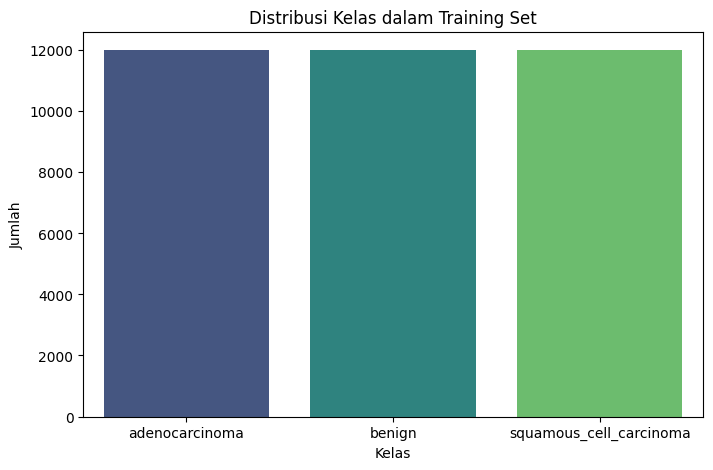

In [18]:
labels = list(train_generator.class_indices.keys())
train_counts = [len(train_generator.filenames) for _ in labels]
plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=train_counts, palette="viridis")
plt.title("Distribusi Kelas dalam Training Set")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.show()

In [19]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
callbacks=[
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
]

In [23]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 145s 370ms/step - accuracy: 0.6987 - loss: 0.6640 - val_accuracy: 0.8800 - val_loss: 0.2795 - learning_rate: 0.0010
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 137s 365ms/step - accuracy: 0.8827 - loss: 0.2901 - val_accuracy: 0.9163 - val_loss: 0.2304 - learning_rate: 0.0010
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 125s 333ms/step - accuracy: 0.8932 - loss: 0.2681 - val_accuracy: 0.9037 - val_loss: 0.2165 - learning_rate: 0.0010
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 125s 333ms/step - accuracy: 0.9030 - loss: 0.2281 - val_accuracy: 0.9217 - val_loss: 0.1839 - learning_rate: 0.0010
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 123s 328ms/step - accuracy: 0.9056 - loss: 0.2319 - val_accuracy: 0.9243 - val_loss: 0.1875 - learning_rate: 0.0010
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 123s 328ms/step - accuracy: 0.9135 - loss: 0.2062 - val_accuracy: 0.9343 - val_loss: 0.1734 - learning_rate: 0.0010
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 122s 324ms/step - accura

In [25]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.4f}")

print(f"Training Accuracy: {max(history.history['accuracy']):.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 ━━━━━━━━━━━━━━━━━━━━ 57s 122ms/step - accuracy: 0.9857 - loss: 0.0450
Test Accuracy: 0.9771
Training Accuracy: 0.9684


In [26]:
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

469/469 ━━━━━━━━━━━━━━━━━━━━ 57s 121ms/step
                         precision    recall  f1-score   support

         adenocarcinoma       0.95      0.98      0.97      5000
                 benign       1.00      1.00      1.00      5000
squamous_cell_carcinoma       0.98      0.95      0.97      5000

               accuracy                           0.98     15000
              macro avg       0.98      0.98      0.98     15000
           weighted avg       0.98      0.98      0.98     15000



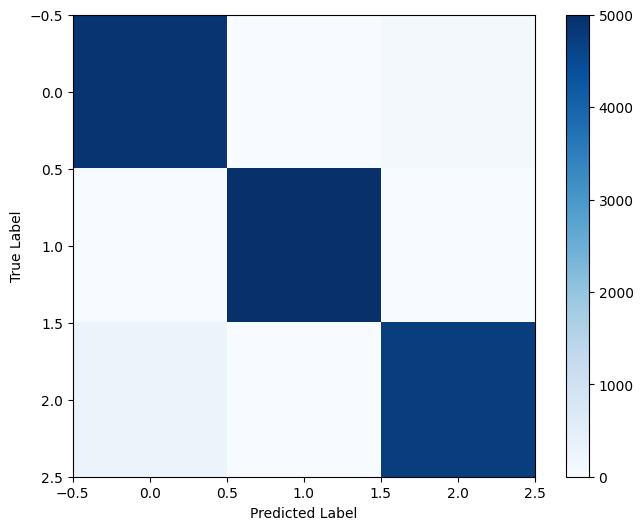

In [27]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.colorbar()
plt.show()

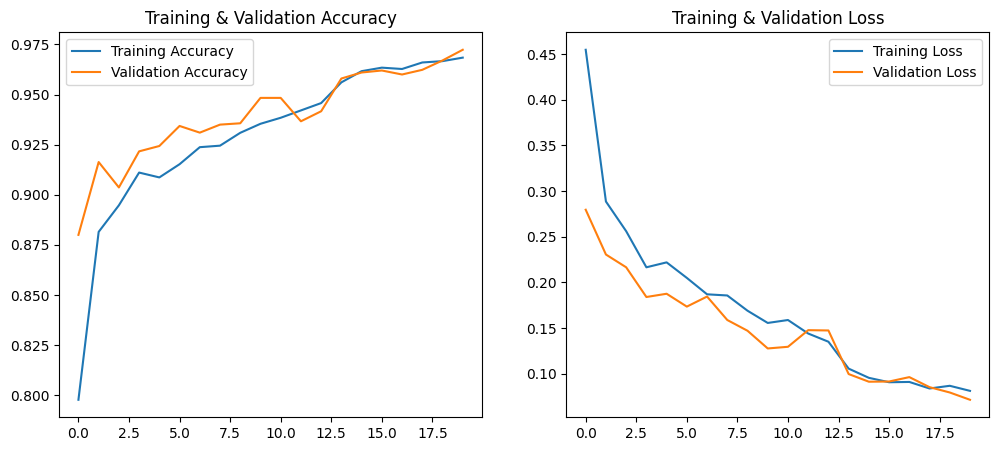

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()

###Save Model

In [38]:
os.makedirs("submission/tfjs_model", exist_ok=True)
tfjs.converters.save_keras_model(model, "submission/tfjs_model")

os.makedirs("submission/tflite", exist_ok=True)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("submission/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)
with open("submission/tflite/label.txt", "w") as f:
    f.write("\n".join(test_generator.class_indices.keys()))

save_path = "submission/saved_model"
os.makedirs(save_path, exist_ok=True)
tf.saved_model.save(model, save_path)

failed to lookup keras version from the file,
    this is likely a weight only file
Saved artifact at '/tmp/tmp6lbci7pm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  133644286396560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133644286409616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133644286410384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133644286405776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133644286406160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133644286409424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133644286397712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133644286410192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133644292932432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  